In [15]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

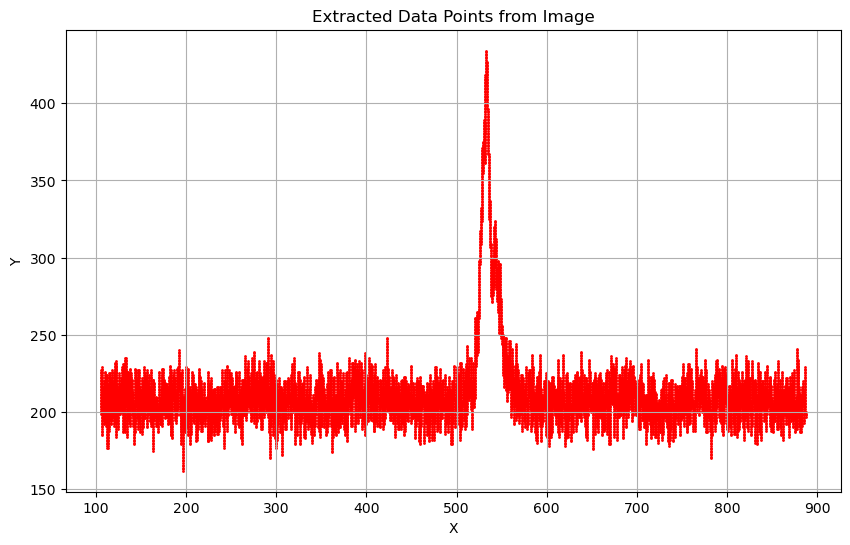

In [9]:

# Görüntüyü oku
img = Image.open("./mrk0348.gif").convert("RGB")
img_hsv = img.convert("HSV")

width, height = img.size
rgb_pixels = img.load()
hsv_pixels = img_hsv.load()

# Veri noktalarının koordinatları burada toplanacak
data_x = []
data_y = []

# HSV kırmızı filtre aralığı
for x in range(width):
    for y in range(height):
        h, s, v = hsv_pixels[x, y]

        # Kırmızı aralıkları: hue 0-10 veya 350-360
        is_red = ((h <= 10 or h >= 350) and s > 50 and v > 50)

        if is_red:
            data_x.append(x)
            data_y.append(height - y)  # y'yi ters çeviriyoruz (görüntü koordinatı <-> grafik koordinatı)

# Sonuçları çiz
plt.figure(figsize=(10, 6))
plt.scatter(data_x, data_y, color='red', s=1)
plt.title("Extracted Data Points from Image")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()


In [10]:
len(data_x), len(data_y)

(22111, 22111)

In [12]:

# Veriyi sırala 
x_data = np.array(data_x)
y_data = np.array(data_y)

sorted_indices = np.argsort(x_data)
x_data = x_data[sorted_indices]
y_data = y_data[sorted_indices]

# pixel ve fiziksel min, max değerleri
x0_data, x1_data = np.min(x_data), np.max(x_data)
x0_true, x1_true = 3150, 5850

# x eksenini fiziksel ölçeğe taşı
x_data_true = (x_data - x0_data) / (x1_data - x0_data) * (x1_true - x0_true) + x0_true

# Normalize x (fit için)
x_min = np.min(x_data_true)
x_max = np.max(x_data_true)
x_scaled = (x_data_true - x_min) / (x_max - x_min)

# Model: lineer + gaussian
def model_line(x, a, b):
    return a * x + b

def model_gauss(x, A, mu, sigma):
    return A * np.exp(-((x - mu)**2) / (2 * sigma**2))

def model(x, a, b, A, mu, sigma):
    return model_line(x, a, b) + model_gauss(x, A, mu, sigma)

# Başlangıç tahminleri (normalize alanda)
initial_guess = [0, np.median(y_data), max(y_data), 0.5, 0.1]
bounds=([ -np.inf, -np.inf, 0, 0, 1e-5], [np.inf, np.inf, np.inf, 1, 1])

# Fit işlemi
params, _ = curve_fit(model, x_scaled, y_data, p0=initial_guess, bounds=bounds)
a, b, A, mu, sigma = params

# Parametreleri fiziksel skala ile geri dönüştür
mu_real = mu * (x_max - x_min) + x_min
sigma_real = sigma * (x_max - x_min)
fwhm = 2.355 * sigma_real

# Fit eğrisini çiz
x_fit = np.linspace(np.min(x_scaled), np.max(x_scaled), 500)
y_fit = model(x_fit, *params)
y_fit_line = model_line(x_fit, *params[:2])

# x'i tekrar fiziksel alana çevir
x_fit_real = x_fit * (x_max - x_min) + x_min


In [13]:
a, b, A, mu_real, sigma_real, fwhm

(0.35158256600910637,
 207.1090414462004,
 162.53160896106263,
 4629.380861548642,
 28.099069853162135,
 66.17330950419682)

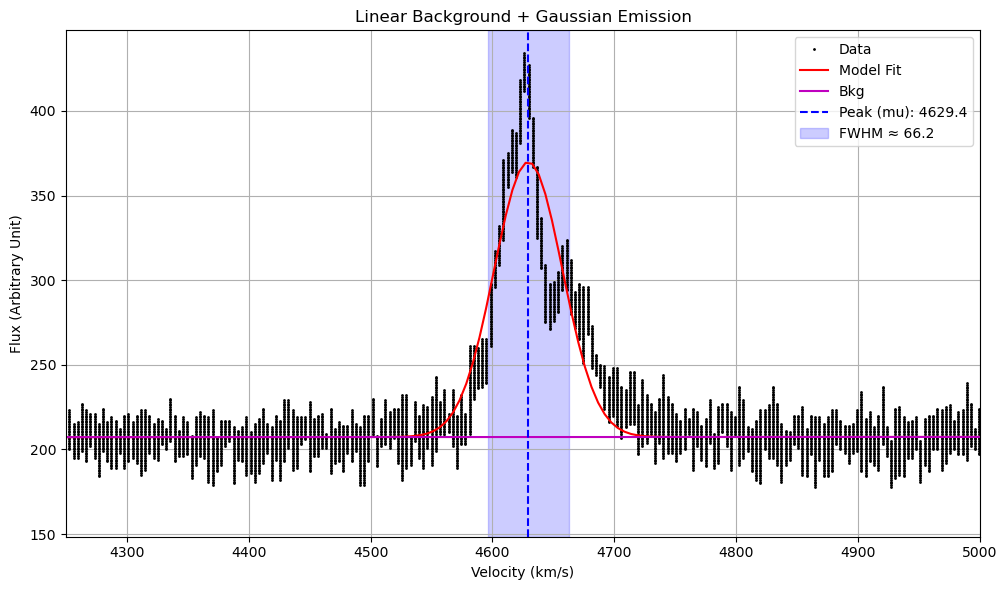

In [14]:

# Grafik
plt.figure(figsize=(10, 6))
plt.plot(x_data_true, y_data, 'ko', markersize=1, label='Data')
plt.plot(x_fit_real, y_fit, 'r-', label='Model Fit')
plt.plot(x_fit_real, y_fit_line, 'm-', label='Bkg')

plt.axvline(mu_real, color='b', linestyle='--', label=f'Peak (mu): {mu_real:.1f}')
plt.axvspan(mu_real - fwhm/2, mu_real + fwhm/2, color='blue', alpha=0.2, label=f'FWHM ≈ {fwhm:.1f}')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Flux (Arbitrary Unit)')
plt.title('Linear Background + Gaussian Emission')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.xlim([4250,5000])

plt.savefig("fit_result.jpg")
plt.show()
